In [ ]:
# The code was removed by Watson Studio for sharing.

 ## CAPSTONE PROJECT
 This notebook will be used for the capstone project Applied Data Science. 
 
 #### Project Title: Thai restaurant in Switzerland 

----------------------------------------------------------------------------
----------------------------------------------------------------------------
### Introduction/Business Problem

The problem we are trying to solve: 

--> we want to open a new Thai restaurant in Switzerland once the Covid-19 crisis is over

--> the new restaurant should be in a densely populated region with strong economic activity and relatively high income 

--> the new restaurant should not be too close to already existing/popular Thai restaurants 

--> so ultimately: where in Switzerland should we open the new superb Thai restaurant?



----------------------------------------------------------------------------
----------------------------------------------------------------------------
### Data

The data (and their sources) required to answer the question: 

1) GDP per capita, from the Swiss Federal Office of Statistics:
https://www.bfs.admin.ch/bfs/de/home/statistiken/volkswirtschaft/volkswirtschaftliche-gesamtrechnung/bruttoinlandprodukt-kanton.assetdetail.10647589.html

2) Income per capita, from the Swiss Federal Office of Statistics:
https://www.bfs.admin.ch/bfs/de/home/statistiken/wirtschaftliche-soziale-situation-bevoelkerung/einkommen-verbrauch-vermoegen/haushaltsbudget.assetdetail.10867286.html


3) Also a file listing the most populous cities in Switzerland, with number of inhabitants per city, will be used. 
This information can be obtained in this site: 
https://opendata.swiss/de/group/population

The following will be used with Python in order to support the project:

4) Nominatim Geopy module to locate the coordinates of cities. 

5) Foursquare location data to identify already existing Thai restaurants in Switzerland.


Data manipulation will be required to identify possible cities to open the new restaurant, therefore first using (3) and (4) mentioned above.
Then it will be necessary to combine data from (1) and (2) to pre-select most interesting regions for such project.
Finally, we will have to exclude some cities from our scope by also using (5) to identify which existing venues would be a competition which we would like to avoid. 





----------------------------------------------------------------------------

## LIBRARIES TO IMPORT

In [1]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

!pip install geopy
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

import matplotlib as mpl
import matplotlib.pyplot as plt 
import seaborn as sns


# import k-means from clustering stage
from sklearn.cluster import KMeans

!pip install folium
import folium # map rendering library

print('Libraries imported.')


     |████████████████████████████████| 102kB 7.9MB/s ta 0:00:011
Libraries imported.


## DATA

In [2]:
# The code was removed by Watson Studio for sharing.

,Gemeinde,Kanton,BFS-Nr.,Einwohner,Fläche,Einwohnerdichte
0,Aadorf,Kanton Thurgau TG,4551,9037,19.93,453.4
1,Aarau,Kanton Aargau AG,4001,21473,12.36,1737.3
2,Aarberg,Kanton Bern BE,301,4628,7.94,582.9
3,Aarburg,Kanton Aargau AG,4271,8362,4.40,1900.5
4,Aarwangen,Kanton Bern BE,321,4561,9.87,462.1


In [3]:
df_data_ch.columns = ['municipality','canton','BFS-Nr.','population','area_sqkm','pop_density']

df_data_ch.head()

,municipality,canton,BFS-Nr.,population,area_sqkm,pop_density
0,Aadorf,Kanton Thurgau TG,4551,9037,19.93,453.4
1,Aarau,Kanton Aargau AG,4001,21473,12.36,1737.3
2,Aarberg,Kanton Bern BE,301,4628,7.94,582.9
3,Aarburg,Kanton Aargau AG,4271,8362,4.40,1900.5
4,Aarwangen,Kanton Bern BE,321,4561,9.87,462.1


In [4]:
df_data_ch.describe()

,BFS-Nr.,population,area_sqkm,pop_density
count,2212.000000,2212.000000,2212.000000,2212.000000
mean,3307.067360,3866.973327,18.079290,432.566004
std,2128.085843,12635.065412,33.005254,785.684169
min,1.000000,11.000000,0.290000,0.900000
25%,1087.500000,699.750000,4.350000,80.000000
50%,3339.500000,1527.000000,8.050000,182.050000
75%,5412.250000,3750.000000,16.567500,461.025000
max,6810.000000,415367.000000,438.760000,12700.900000


In [5]:
#looking for missing data

missing_data = df_data_ch.isnull()

for column in missing_data.columns.values.tolist():
    print(column)
    print (missing_data[column].value_counts())
    print("-------------------------------------------")    


municipality
False    2212
Name: municipality, dtype: int64
-------------------------------------------
canton
False    2212
Name: canton, dtype: int64
-------------------------------------------
BFS-Nr.
False    2212
Name: BFS-Nr., dtype: int64
-------------------------------------------
population
False    2212
Name: population, dtype: int64
-------------------------------------------
area_sqkm
False    2212
Name: area_sqkm, dtype: int64
-------------------------------------------
pop_density
False    2212
Name: pop_density, dtype: int64
-------------------------------------------


In [6]:
# address 

def address_formula(x):
    return x + ", Switzerland"


df_data_ch['address']= df_data_ch.apply(lambda row: address_formula(row['municipality']), axis=1)


df_data_ch.head()

    

,municipality,canton,BFS-Nr.,population,area_sqkm,pop_density,address
0,Aadorf,Kanton Thurgau TG,4551,9037,19.93,453.4,"Aadorf, Switzerland"
1,Aarau,Kanton Aargau AG,4001,21473,12.36,1737.3,"Aarau, Switzerland"
2,Aarberg,Kanton Bern BE,301,4628,7.94,582.9,"Aarberg, Switzerland"
3,Aarburg,Kanton Aargau AG,4271,8362,4.40,1900.5,"Aarburg, Switzerland"
4,Aarwangen,Kanton Bern BE,321,4561,9.87,462.1,"Aarwangen, Switzerland"


In [7]:
#identify the 7 most populous cantons in Switzerland, which is our initial scope 

df_cantons = df_data_ch.groupby(['canton'])['population'].sum().reset_index()
df_cantons = df_cantons.sort_values(by = ['population'], ascending=False)

df_init_scope = df_cantons.head(7)
df_init_scope['canton'] = df_init_scope['canton'].str.replace('Kanton ','')
df_init_scope

/opt/conda/envs/Python36/lib/python3.6/site-packages/ipykernel/__main__.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,canton,population
25,Zürich ZH,1520968
5,Bern BE,1035068
22,Waadt VD,799145
0,Aargau AG,686508
18,St. Gallen SG,507697
7,Genf GE,499480
11,Luzern LU,409935


In [8]:
# load GDP data 
body = client_2e3489323a1942b3a3173fcbace005b1.get_object(Bucket='courseracapstoneonibm-donotdelete-pr-7l7njlsu92rnh7',Key='CH_BIP_pro_Einwohner.csv')['Body']
# add missing __iter__ method, so pandas accepts body as file-like object
if not hasattr(body, "__iter__"): body.__iter__ = types.MethodType( __iter__, body )

df_gdp = pd.read_csv(body)

df_gdp.columns = ['canton','GDP']
df_gdp.head()


,canton,GDP
0,Zürich ZH,95607.83790
1,Bern BE,76084.92353
2,Luzern LU,66655.23951
3,Uri UR,52467.93176
4,Schwyz SZ,60312.99298


In [9]:
# load income data 

body = client_2e3489323a1942b3a3173fcbace005b1.get_object(Bucket='courseracapstoneonibm-donotdelete-pr-7l7njlsu92rnh7',Key='CH_Verfuegbares_Einkommen.csv')['Body']
# add missing __iter__ method, so pandas accepts body as file-like object
if not hasattr(body, "__iter__"): body.__iter__ = types.MethodType( __iter__, body )

df_income = pd.read_csv(body)

df_income.columns = ['canton','income']
df_income.head()


,canton,income
0,Zürich ZH,7829.343369
1,Bern BE,6388.811173
2,Luzern LU,7208.037811
3,St. Gallen SG,6617.487930
4,Aargau AG,7244.318060


In [10]:
#CONCATENATE

df_scope = df_init_scope[['canton', 'population']].copy()

df_scope = pd.merge(df_scope, df_gdp, on=['canton'])

df_scope = pd.merge(df_scope, df_income, on=['canton'])

df_scope


,canton,population,GDP,income
0,Zürich ZH,1520968,95607.83790,7829.343369
1,Bern BE,1035068,76084.92353,6388.811173
2,Waadt VD,799145,68102.12356,7282.004982
3,Aargau AG,686508,62336.51043,7244.318060
4,St. Gallen SG,507697,73058.67656,6617.487930
5,Genf GE,499480,100464.27650,7127.030646
6,Luzern LU,409935,66655.23951,7208.037811


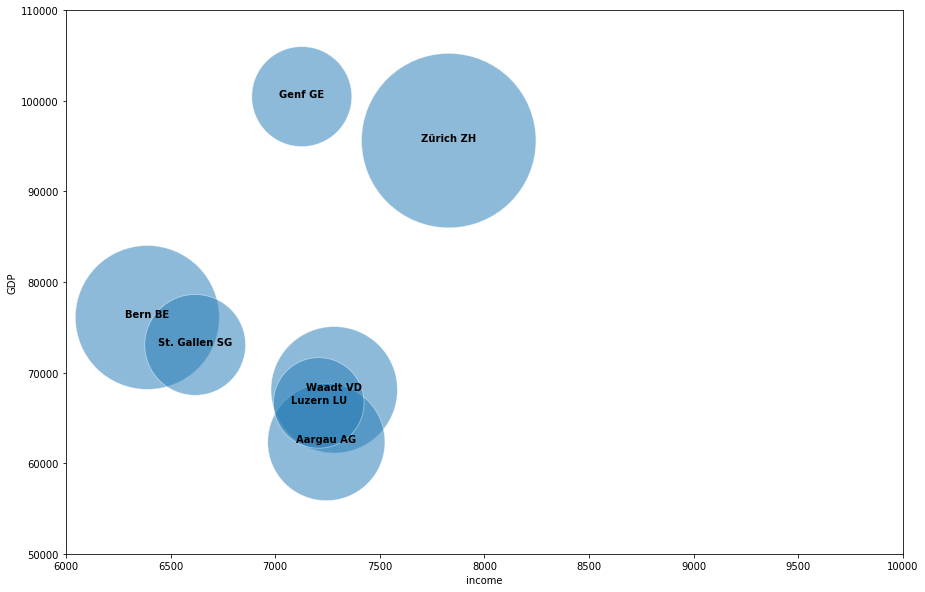

In [11]:
# Bubble Scatter Chart 

#Create figure
plt.figure(figsize = (15,10))

# Create scatterplot. alpha controls the opacity and s controls the size.
ax = sns.scatterplot(df_scope.income, df_scope.GDP, alpha = 0.5,s = df_scope.population/50)

ax.set_xlim(6000,10000)
ax.set_ylim(50000, 110000)

#For each point, we add a text inside the bubble
for line in range(0,df_scope.shape[0]):
     ax.text(df_scope.income[line], df_scope.GDP[line], df_scope.canton[line], horizontalalignment='center', size='medium', color='black', weight='semibold')

In [12]:
# Filter only top 7 cantons (population)

df_data_ch_narrow = df_data_ch[df_data_ch['canton'].isin(['Kanton Zürich ZH','Kanton Bern BE','Kanton Waadt VD','Kanton Aargau AG','Kanton St. Gallen SG','Kanton Genf GE','Kanton Luzern LU',])]



In [13]:
# Filter only municipalities with population greater than 5'000 inhabitants

pop_gt5000 = df_data_ch_narrow['population']>=5000
df_data_ch_gt5000 = df_data_ch_narrow[pop_gt5000]
print(df_data_ch_gt5000.shape)




(251, 7)


In [14]:
#  identify latitute, longitude  

def lat_formula(x):
    geolocator = Nominatim(user_agent="foursquare_agent")
    location = geolocator.geocode(x)
    return location.latitude

df_data_ch_gt5000['latitude']= df_data_ch_gt5000.apply(lambda row: lat_formula(row['address']), axis=1)

def lon_formula(x):
    geolocator = Nominatim(user_agent="foursquare_agent")
    location = geolocator.geocode(x)
    return location.longitude

df_data_ch_gt5000['longitude']= df_data_ch_gt5000.apply(lambda row: lon_formula(row['address']), axis=1)

df_data_ch_gt5000.head(10)

/opt/conda/envs/Python36/lib/python3.6/site-packages/ipykernel/__main__.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/opt/conda/envs/Python36/lib/python3.6/site-packages/ipykernel/__main__.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,municipality,canton,BFS-Nr.,population,area_sqkm,pop_density,address,latitude,longitude
1,Aarau,Kanton Aargau AG,4001,21473,12.36,1737.3,"Aarau, Switzerland",47.392715,8.044445
3,Aarburg,Kanton Aargau AG,4271,8362,4.40,1900.5,"Aarburg, Switzerland",47.320642,7.899360
9,Adligenswil,Kanton Luzern LU,1051,5391,6.98,772.3,"Adligenswil, Switzerland",47.070535,8.368244
11,Adliswil,Kanton Zürich ZH,131,18769,7.78,2412.5,"Adliswil, Switzerland",47.311762,8.524910
22,Affoltern am Albis,Kanton Zürich ZH,2,12229,10.53,1161.3,"Affoltern am Albis, Switzerland",47.278247,8.452152
27,Aigle,Kanton Waadt VD,5401,10119,16.50,613.3,"Aigle, Switzerland",46.317901,6.968893
48,Altstätten,Kanton St. Gallen SG,3251,11733,39.56,296.6,"Altstätten, Switzerland",47.378347,9.541277
89,Au (SG),Kanton St. Gallen SG,3231,7789,4.66,1671.5,"Au (SG), Switzerland",47.424918,9.638211
108,Bad Ragaz,Kanton St. Gallen SG,3291,6102,25.43,240.0,"Bad Ragaz, Switzerland",47.002528,9.501644
110,Baden,Kanton Aargau AG,4021,19578,13.19,1484.3,"Baden, Switzerland",47.473683,8.308682


In [16]:
# function for nearby venues "Thai Restaurant" within 5 km 

def getNearbyVenues(names, latitudes, longitudes, radius=5000, search_query = 'Thai Restaurant'):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
#url = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&ll={},{}&v={}&query={}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, latitude, longitude, VERSION, search_query, radius, LIMIT)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&query={}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng,
            search_query,
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['id'],
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],             
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Municipality', 
                  'Municipality_Latitude', 
                  'Municipality_Longitude', 
                  'Venue',
                  'Id',           
                  'Venue_Latitude', 
                  'Venue_Longitude', 
                  'Venue_Category']
    
    return(nearby_venues)

In [17]:
 
# function for RATINGS 

def getVenueRatings(Id):
    
    venues_list=[]
    for Id in zip(Id):
        print(Id)
            
#url = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&ll={},{}&v={}&query={}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, latitude, longitude, VERSION, search_query, radius, LIMIT)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/{}?client_id={}&client_secret={}&v={}'.format(
            Id, 
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION)    
        
        # make the GET request
        result = requests.get(url).json()
        
        # return only relevant information for each nearby venue
        try:
            venues_list.append([(Id,result['response']['venue']['rating'])])
        except:
            No_Rating = 'NaN' 
            venues_list.append([(Id,No_Rating)])      
        

    venue_ratings = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    venue_ratings.columns = ['Id', 
                  'Rating']
    
    return(venue_ratings)
    
    
    
    

In [17]:
df_data_ch_gt5000.head(10)

,municipality,canton,BFS-Nr.,population,area_sqkm,pop_density,address,latitude,longitude
1,Aarau,Kanton Aargau AG,4001,21473,12.36,1737.3,"Aarau, Switzerland",47.392715,8.044445
3,Aarburg,Kanton Aargau AG,4271,8362,4.40,1900.5,"Aarburg, Switzerland",47.320642,7.899360
9,Adligenswil,Kanton Luzern LU,1051,5391,6.98,772.3,"Adligenswil, Switzerland",47.070535,8.368244
11,Adliswil,Kanton Zürich ZH,131,18769,7.78,2412.5,"Adliswil, Switzerland",47.311762,8.524910
22,Affoltern am Albis,Kanton Zürich ZH,2,12229,10.53,1161.3,"Affoltern am Albis, Switzerland",47.278247,8.452152
27,Aigle,Kanton Waadt VD,5401,10119,16.50,613.3,"Aigle, Switzerland",46.317901,6.968893
48,Altstätten,Kanton St. Gallen SG,3251,11733,39.56,296.6,"Altstätten, Switzerland",47.378347,9.541277
89,Au (SG),Kanton St. Gallen SG,3231,7789,4.66,1671.5,"Au (SG), Switzerland",47.424918,9.638211
108,Bad Ragaz,Kanton St. Gallen SG,3291,6102,25.43,240.0,"Bad Ragaz, Switzerland",47.002528,9.501644
110,Baden,Kanton Aargau AG,4021,19578,13.19,1484.3,"Baden, Switzerland",47.473683,8.308682


In [20]:
# Get venues from Foursquare

municipalities_venues = getNearbyVenues(names=df_data_ch_gt5000['address'],
                                   latitudes=df_data_ch_gt5000['latitude'],
                                   longitudes=df_data_ch_gt5000['longitude']
                                  )

Aarau, Switzerland
Aarburg, Switzerland
Adligenswil, Switzerland
Adliswil, Switzerland
Affoltern am Albis, Switzerland
Aigle, Switzerland
Altstätten, Switzerland
Au (SG), Switzerland
Bad Ragaz, Switzerland
Baden, Switzerland
Bäretswil, Switzerland
Bassersdorf, Switzerland
Belp, Switzerland
Bern, Switzerland
Bernex, Switzerland
Beromünster, Switzerland
Bex, Switzerland
Biel/Bienne, Switzerland
Birmensdorf (ZH), Switzerland
Blonay, Switzerland
Bolligen, Switzerland
Bonstetten, Switzerland
Bourg-en-Lavaux, Switzerland
Bremgarten (AG), Switzerland
Brugg, Switzerland
Bubikon, Switzerland
Buchrain, Switzerland
Buchs (AG), Switzerland
Buchs (SG), Switzerland
Buchs (ZH), Switzerland
Bülach, Switzerland
Burgdorf, Switzerland
Bussigny, Switzerland
Carouge (GE), Switzerland
Chavannes-près-Renens, Switzerland
Chavornay, Switzerland
Chêne-Bougeries, Switzerland
Chêne-Bourg, Switzerland
Collonge-Bellerive, Switzerland
Cologny, Switzerland
Crissier, Switzerland
Dagmersellen, Switzerland
Dielsdorf, Sw

In [21]:
municipalities_venues.head(10)
#municipalities_venues.drop(municipalities_venues.index, inplace=True)

,Municipality,Municipality_Latitude,Municipality_Longitude,Venue,Id,Venue_Latitude,Venue_Longitude,Venue_Category
0,"Aarau, Switzerland",47.392715,8.044445,Thai House,4b7d25fbf964a52052b02fe3,47.391718,8.049653,Thai Restaurant
1,"Aarau, Switzerland",47.392715,8.044445,Thai Time,5106b748e4b0280b1810f2ec,47.392698,8.044671,Thai Restaurant
2,"Aarau, Switzerland",47.392715,8.044445,Restaurant Löwen,513b6517e4b0c4aa132a19f3,47.396683,8.009302,Thai Restaurant
3,"Aarau, Switzerland",47.392715,8.044445,Maliwan Thai Restaurant,5d164296c195980023910c16,47.372622,7.988271,Thai Restaurant
4,"Aarburg, Switzerland",47.320642,7.899360,Goldener Löwen Lanna Thai,4ffc0159e4b0565afd917efa,47.349816,7.904417,Thai Restaurant
5,"Aarburg, Switzerland",47.320642,7.899360,Pavillon,53219ae711d21f6fdd30b78c,47.347449,7.908760,Thai Restaurant
6,"Aarburg, Switzerland",47.320642,7.899360,Typisch Thai Oftringen,533f0a75498eb6afb26b04fc,47.313195,7.919940,Thai Restaurant
7,"Aarburg, Switzerland",47.320642,7.899360,Baan Thai Restaurant,4fa62079e4b0fd4c3f894746,47.308735,7.873489,Thai Restaurant
8,"Aarburg, Switzerland",47.320642,7.899360,Restaurant Löwen,513b65ade4b017813e98f5de,47.349119,7.904343,Thai Restaurant
9,"Aarburg, Switzerland",47.320642,7.899360,The Guest,50faf0e0e4b064cc811caec7,47.351518,7.900468,Thai Restaurant


In [31]:
#path='C:\\Users\\maan7\\Desktop\\'
#municipalities_venues.to_csv('VenuesFourSquare.csv')
#municipalities_venues.to_csv(path+'VenuesFourSquare.csv')

# Save dataframe as csv file to storage
#project.save_data(data=municipalities_venues.to_csv(index=False),file_name='VenuesFourSquare.csv',overwrite=True)

#print(municipalities_venues.shape)

municipalities_venues

,Municipality,Municipality_Latitude,Municipality_Longitude,Venue,Id,Venue_Latitude,Venue_Longitude,Venue_Category
0,"Aarau, Switzerland",47.392715,8.044445,Thai House,4b7d25fbf964a52052b02fe3,47.391718,8.049653,Thai Restaurant
1,"Aarau, Switzerland",47.392715,8.044445,Thai Time,5106b748e4b0280b1810f2ec,47.392698,8.044671,Thai Restaurant
2,"Aarau, Switzerland",47.392715,8.044445,Restaurant Löwen,513b6517e4b0c4aa132a19f3,47.396683,8.009302,Thai Restaurant
3,"Aarau, Switzerland",47.392715,8.044445,Maliwan Thai Restaurant,5d164296c195980023910c16,47.372622,7.988271,Thai Restaurant
4,"Aarburg, Switzerland",47.320642,7.899360,Goldener Löwen Lanna Thai,4ffc0159e4b0565afd917efa,47.349816,7.904417,Thai Restaurant
5,"Aarburg, Switzerland",47.320642,7.899360,Pavillon,53219ae711d21f6fdd30b78c,47.347449,7.908760,Thai Restaurant
6,"Aarburg, Switzerland",47.320642,7.899360,Typisch Thai Oftringen,533f0a75498eb6afb26b04fc,47.313195,7.919940,Thai Restaurant
7,"Aarburg, Switzerland",47.320642,7.899360,Baan Thai Restaurant,4fa62079e4b0fd4c3f894746,47.308735,7.873489,Thai Restaurant
8,"Aarburg, Switzerland",47.320642,7.899360,Restaurant Löwen,513b65ade4b017813e98f5de,47.349119,7.904343,Thai Restaurant
9,"Aarburg, Switzerland",47.320642,7.899360,The Guest,50faf0e0e4b064cc811caec7,47.351518,7.900468,Thai Restaurant


In [27]:
df_CountThai = municipalities_venues.groupby('Municipality').count()
df_CountThai

,Municipality_Latitude,Municipality_Longitude,Venue,Id,Venue_Latitude,Venue_Longitude,Venue_Category
Municipality,,,,,,,
"Aarau, Switzerland",4,4,4,4,4,4,4
"Aarburg, Switzerland",8,8,8,8,8,8,8
"Adligenswil, Switzerland",5,5,5,5,5,5,5
"Adliswil, Switzerland",4,4,4,4,4,4,4
"Affoltern am Albis, Switzerland",2,2,2,2,2,2,2
"Aigle, Switzerland",3,3,3,3,3,3,3
"Altstätten, Switzerland",1,1,1,1,1,1,1
"Au (SG), Switzerland",2,2,2,2,2,2,2
"Baden, Switzerland",5,5,5,5,5,5,5


In [28]:
#bins = np.linspace(min(df_CountThai['Venue']),max(df_CountThai['Venue']),6)
bins = ([1.,3.,7.,10.,25.,57.])
group_names = ["A: 1-3  ","B: 4-7  ","C: 8-10 ","D: 11-25","E: 26+  "]
df_CountThai["Classification"] = pd.cut(df_CountThai["Venue"], bins, labels=group_names, include_lowest=True)

In [29]:
df_CountThai["Classification"].head(15)

Municipality
Aarau, Switzerland                 B: 4-7  
Aarburg, Switzerland               C: 8-10 
Adligenswil, Switzerland           B: 4-7  
Adliswil, Switzerland              B: 4-7  
Affoltern am Albis, Switzerland    A: 1-3  
Aigle, Switzerland                 A: 1-3  
Altstätten, Switzerland            A: 1-3  
Au (SG), Switzerland               A: 1-3  
Baden, Switzerland                 B: 4-7  
Bassersdorf, Switzerland           A: 1-3  
Belp, Switzerland                  A: 1-3  
Bern, Switzerland                  C: 8-10 
Bernex, Switzerland                A: 1-3  
Beromünster, Switzerland           A: 1-3  
Bex, Switzerland                   A: 1-3  
Name: Classification, dtype: category
Categories (5, object): [A: 1-3 < B: 4-7 < C: 8-10 < D: 11-25 < E: 26+]

In [30]:
df_CountThai['Classification'].value_counts()

A: 1-3      105
B: 4-7       69
C: 8-10      16
D: 11-25     12
E: 26+        8
Name: Classification, dtype: int64

In [ ]:
#df_municipalities_venues = pd.merge(municipalities_venues,df_CountThai[['Municipality','Venue','Classification']],on='Municipality', how='left')
#df_municipalities_venues.head()

In [33]:
# define CH's geolocation coordinates
CH_latitude = 46.948271
CH_longitude = 7.451451

# define the world map centered around CH with a higher zoom level
CH_map = folium.Map(location=[CH_latitude, CH_longitude], zoom_start=9)

# display map
#CH_map

In [34]:

# instantiate a feature group for the venues in the dataframe
Municipalities = folium.map.FeatureGroup()
ThaiVenues = folium.map.FeatureGroup()



# loop through the municipalities and add each to the feature group

for lat, lng, in zip(df_data_ch_gt5000.latitude, df_data_ch_gt5000.longitude):
    Municipalities.add_child(
        folium.CircleMarker(
            [lat, lng],
            radius=5, # define how big you want the circle markers to be
            color='yellow',
            fill=True,
            fill_color='yellow',
            fill_opacity=0.6
        )
    )



# loop through the venues and add each to the feature group

for lat, lng, in zip(municipalities_venues.Venue_Latitude, municipalities_venues.Venue_Longitude):
    ThaiVenues.add_child(
        folium.CircleMarker(
            [lat, lng],
            radius=3, # define how big you want the circle markers to be
            color='red',
            fill=True,
            fill_color='white',
            fill_opacity=0.4
        )
    )
  
    
# add venue to map
CH_map.add_child(Municipalities)
#####
CH_map.add_child(ThaiVenues)